# Long Short-Term Memory (LSTM) - By Foivos Gaitantzis

#### This section of the program is dedicated to fitting all the features post processing to a Long Short-Term Memory (LSTM) Algorithm. An initial model is built using random hyperparametes. The hyperparameter values are then tweaked and a final model is built and evaluated. 

### Load the Libraries

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dropout

### Define the Feature Engineering/Machine Learning Parameters & Utility Functions

In [12]:
#Set the filename
filename = 'aapl'

#Set the Default Columns, Timestep (Previous Historical Data to Use for Predictions) & Polynomial Degree
Columns = ['Adj Close', 'compoundFT', 'compoundNYTimes', 'compoundBS', 'Volume', 'RSI', 'MACD']
timestep = 3
neurons = 128
dropout = 1
optimizer = 'nadam'
epochs = 1
batch_size = 8

In [13]:
#Utility function to compute the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

#Utility function to split data into mini batches (timestep) of features x and output y
def get_input_output(data, timestep, pred_column):
    x, y = [], []
    for i in range(timestep, len(data)):
        x.append(data[i-timestep:i])
        y.append(data[i, pred_column])
    x = np.array(x)
    y = np.array(y)
    return x, y

#Utility function to split data into mini batches (timestep) of features x and output y and scale their features
def get_input_scaled_output(data, timestep, pred_column):
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(timestep, len(data)):
        mu_list.append(np.mean(data[i-timestep:i, pred_column]))
        std_list.append(np.std(data[i-timestep:i, pred_column]))
        x_scaled.append((data[i-timestep:i]-mu_list[i-timestep])/std_list[i-timestep])
        y.append(data[i, pred_column])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    return x_scaled, y, mu_list, std_list

### Load the Data File & Perform Model Feature Engineering

In [14]:
#Load the Daily Stock Data
Data = pd.read_csv('files/'+filename+'_Stock_Data_Full.csv')

#Set the Date Column Type to Datetime
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')

#Remove all NaN values in Adj Close, Predicted Adj Close, RSI and MACD
Data.dropna(inplace = True)

#Display the first 5 rows of the Modified Data Set
Data.head()

,Date,compoundFT,compoundNYTimes,compoundBS,Close,Volume,Adj Close,RSI,MACD,Predicted Adj Close
7,2016-01-08,0.203480,0.043943,0.137486,96.959999,7.079800e+07,90.391907,14.668720,-0.370537,90.879794
8,2016-01-09,0.377325,-0.008900,0.104625,97.483332,6.377847e+07,90.879794,14.832344,-0.384101,91.367681
9,2016-01-10,0.515333,0.271481,0.135400,98.006666,5.675893e+07,91.367681,14.886746,-0.364081,91.855568
10,2016-01-11,0.233810,0.375018,0.179233,98.529999,4.973940e+07,91.855568,14.913921,-0.321599,93.188705
11,2016-01-12,0.155050,0.201992,0.397150,99.959999,4.915420e+07,93.188705,19.135019,-0.221146,90.792793


In [15]:
#Split the Data into Training and Testing (Train: 80% & Testing: 20%)
train, test = train_test_split(Data, train_size = 0.8, test_size = 0.2, shuffle = False)

#Initialize the Scaler for the Training Data
scaler = StandardScaler()

#Fit the Scaler into the Training Data
train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

#Split Training Data into Features X and Outputs Y 
x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

#Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), timestep, 0)

### Run the Primary LSTM Model using Default Parameters

In [16]:
# Create the LSTM network
Model = Sequential()

#Add an LSTM Unit with Input Size train(rows, columns)
Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))

#Add a Droupout unit
Model.add(Dropout(dropout))

#Add an LSTM Unit
Model.add(LSTM(units=neurons))

#Add a Droupout unit
Model.add(Dropout(dropout))

#Add a Dense Layer
Model.add(Dense(1))

#Configure the Model's Learning Process
Model.compile(loss='mean_squared_error', optimizer=optimizer)

#Show a summary of the Model
Model.summary()

#Fit the Training Data into the Model
Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.2, shuffle=False)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 3, 128)            69632     
_________________________________________________________________
dropout_63 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 201,345
Trainable params: 201,345
Non-trainable params: 0
_________________________________________________________________
Train on 693 samples, validate on 174 samples
Epoch 1/1
 - 1s - loss: 0.1216 - val_loss: 0.0262


In [17]:
#Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

#Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)

#Print the values of RMSE & MAPE
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'][timestep:], 'Actual Value': test['Predicted Adj Close'][timestep:], 'Prediction': Prediction.reshape(-1)})

#Display the first 5 rows of this Dataframe
Prediction.head()

RMSE: 5.0013268919040055
MAPE: 12.061792657866016


,Date,Actual Value,Prediction
880,2018-05-30,182.389633,183.632843
881,2018-05-31,185.678833,183.443996
882,2018-06-01,186.196136,183.149504
883,2018-06-02,186.713440,184.449329
884,2018-06-03,187.230743,185.650161


### Display Primary Model Predictions vs Actual Values

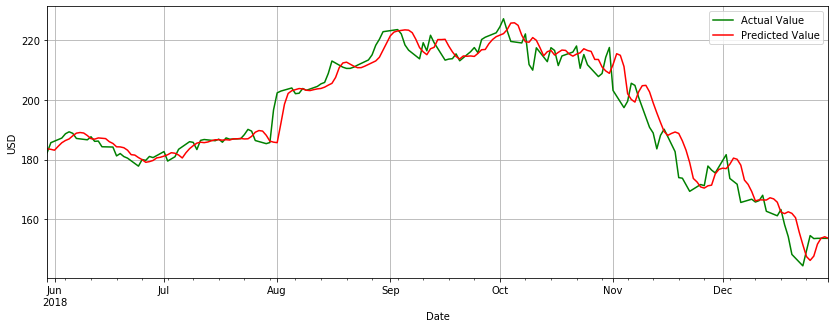

In [18]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()

### Calculate the Optimal Columns Type

In [19]:
columns_list = [['Adj Close', 'Volume'], ['Adj Close', 'Volume', 'RSI', 'MACD'], ['Adj Close', 'Volume', 'compoundFT', 'compoundNYTimes'], Columns]
columns_headers = ['Just Historical Stock Data', 'Technical Analysis', 'Sentiment Analysis', 'Technical & Sentiment Analysis']

columns_errors = {'Columns' : [], 'Columns Type' : [], 'RMSE' : [], 'MAPE' : []}
i = 0

for column in columns_list:   
    
    #Initialize the Scaler for the Training Data
    scaler = StandardScaler()

    #Fit the Scaler into the Training Data
    train_scaled = scaler.fit_transform(np.array(train[column]).reshape(-1, len(column)))

    #Split Training Data into Features X and Outputs Y 
    x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

    #Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
    x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[column]).reshape(-1, len(column)), timestep, 0)
    
    # Create the LSTM network
    Model = Sequential()

    #Add an LSTM Unit with Input Size train(rows, columns)
    Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(column))))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add an LSTM Unit
    Model.add(LSTM(units=neurons))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add a Dense Layer
    Model.add(Dense(1))

    #Configure the Model's Learning Process
    Model.compile(loss='mean_squared_error', optimizer=optimizer)

    #Fit the Training Data into the Model
    Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
    Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

    #Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)  
    
    #Input the Columns, Columns Type & Errors to the Dataframe
    columns_errors['Columns'].append(column)
    columns_errors['Columns Type'].append(columns_headers[i])
    columns_errors['RMSE'].append(RMSE)
    columns_errors['MAPE'].append(MAPE)
    
    i+=1
    
columns_errors = pd.DataFrame(columns_errors)
                              
#Set the Data Column as Index Column
columns_errors = columns_errors.set_index('Columns Type')

#Print the Optimal Columns Type
OptimalParameter = columns_errors[columns_errors['RMSE'] == columns_errors['RMSE'].min()]
Columns = OptimalParameter['Columns'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter.index.values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

#Show each Columns Type and Error Associated
columns_errors[['RMSE', 'MAPE']].head()

Optimal Parameter (Based on RMSE): Technical & Sentiment Analysis, RMSE: 4.4790855671668455


,RMSE,MAPE
Columns Type,,
Just Historical Stock Data,4.813109,11.991198
Technical Analysis,4.602581,12.012741
Sentiment Analysis,4.559326,12.006513
Technical & Sentiment Analysis,4.479086,11.989529


### Calculate the Optimal Timestep

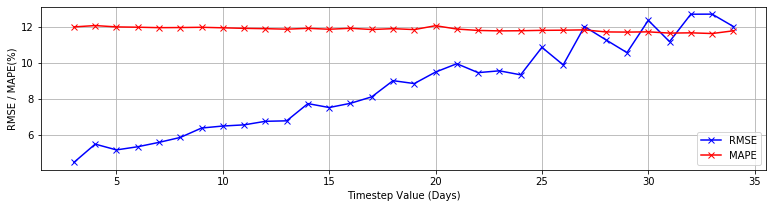

Optimal Parameter (Based on RMSE): 3, RMSE: 4.478553689167974


In [20]:
timestep_list = range(3, 35)

timestep_errors = {'Timestep' : [], 'RMSE' : [], 'MAPE' : []}

for step in timestep_list:   

    #Initialize the Scaler for the Training Data
    scaler = StandardScaler()

    #Fit the Scaler into the Training Data
    train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

    #Split Training Data into Features X and Outputs Y 
    x_train_scaled, y_train_scaled = get_input_output(train_scaled, step, 0)

    #Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
    x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), step, 0)
    
    # Create the LSTM network
    Model = Sequential()

    #Add an LSTM Unit with Input Size train(rows, columns)
    Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add an LSTM Unit
    Model.add(LSTM(units=neurons))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add a Dense Layer
    Model.add(Dense(1))

    #Configure the Model's Learning Process
    Model.compile(loss='mean_squared_error', optimizer=optimizer)

    #Fit the Training Data into the Model
    Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
    Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

    #Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][step:], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][step:], Prediction)  
    
    #Input the Timestep & Errors to the Dataframe
    timestep_errors['Timestep'].append(step)
    timestep_errors['RMSE'].append(RMSE)
    timestep_errors['MAPE'].append(MAPE)
    
timestep_errors = pd.DataFrame(timestep_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 13, 3 
AX = timestep_errors.plot(x='Timestep', y='RMSE', style='bx-', grid=True)
AX = timestep_errors.plot(x='Timestep', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Timestep Value (Days)")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = timestep_errors[timestep_errors['RMSE'] == timestep_errors['RMSE'].min()]
timestep = OptimalParameter['Timestep'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Timestep'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate Optimal Epochs & Batch Size

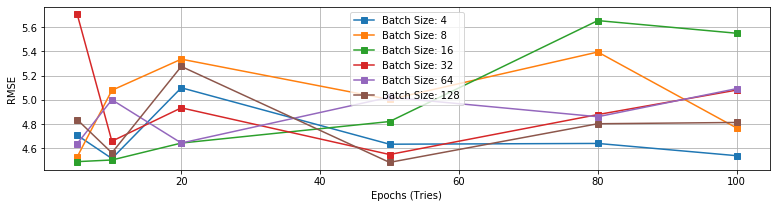

Optimal Parameter (Based on RMSE) -> Batch Size: 128, Epochs: 50, RMSE: 4.48426483011102


In [21]:
epochs_list = [5, 10, 20, 50, 80, 100]
batch_size_list = [4, 8, 16, 32, 64, 128]

errors = {'Epochs' : [], 'Batch Size': [], 'RMSE' : [], 'MAPE' : []}

for epoch in epochs_list:
    for size in batch_size_list:

        #Initialize the Scaler for the Training Data
        scaler = StandardScaler()

        #Fit the Scaler into the Training Data
        train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

        #Split Training Data into Features X and Outputs Y 
        x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

        #Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
        x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), timestep, 0)

        # Create the LSTM network
        Model = Sequential()

        #Add an LSTM Unit with Input Size train(rows, columns)
        Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))
        #Add a Droupout unit
        Model.add(Dropout(dropout))
        #Add an LSTM Unit
        Model.add(LSTM(units=neurons))
        #Add a Droupout unit
        Model.add(Dropout(dropout))
        #Add a Dense Layer
        Model.add(Dense(1))

        #Configure the Model's Learning Process
        Model.compile(loss='mean_squared_error', optimizer=optimizer)

        #Fit the Training Data into the Model
        Model.fit(x_train_scaled, y_train_scaled, epochs=epoch, batch_size=size, verbose=0)

        #Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
        Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

        #Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
        RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
        MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)  

        #Input the Epochs, Batch Size & Errors to the Dataframe
        errors['Epochs'].append(epoch)
        errors['Batch Size'].append(size)
        errors['RMSE'].append(RMSE)
        errors['MAPE'].append(MAPE)
    
errors = pd.DataFrame(errors)

#Plot the Errors against the Timestep
legend_list = []
plt.rcParams['figure.figsize'] = 13, 3 
error = errors[errors['Batch Size'] == batch_size_list[0]]
AX = error.plot(x='Epochs', y='RMSE', marker='s', grid=True)
legend_list.append("Batch Size: "+str(batch_size_list[0]))

for i in range(1, len(batch_size_list)):
    error = errors[errors['Batch Size'] == batch_size_list[i]]
    AX = error.plot(x='Epochs', y='RMSE', marker='s', grid=True, ax=AX)
    legend_list.append("Batch Size: "+str(batch_size_list[i]))
    
AX.set_xlabel("Epochs (Tries)")
AX.set_ylabel("RMSE")
plt.legend(legend_list)
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = errors[errors['RMSE'] == errors['RMSE'].min()]
batch_size = OptimalParameter['Batch Size'].values[0]
epochs = OptimalParameter['Epochs'].values[0]
print("Optimal Parameter (Based on RMSE) -> Batch Size: "+str(OptimalParameter['Batch Size'].values[0])+", Epochs: "+str(OptimalParameter['Epochs'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate Optimal Neurons (LSTM Units) and Dropout Probability

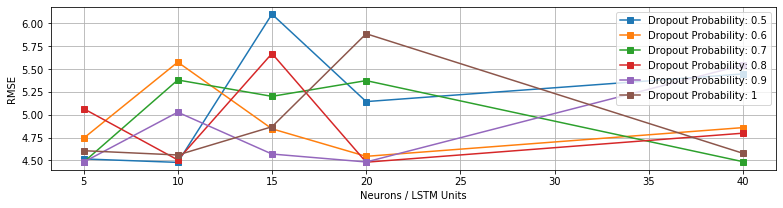

Optimal Parameter (Based on RMSE) -> Dropout: 0.5, Neurons / LSTM Units: 10, RMSE: 4.4784859269560195


In [22]:
neurons_list = [5, 10, 15, 20, 40]
dropout_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

errors = {'Neurons' : [], 'Dropout': [], 'RMSE' : [], 'MAPE' : []}

for unit in neurons_list:
    for prob in dropout_list:

        #Initialize the Scaler for the Training Data
        scaler = StandardScaler()

        #Fit the Scaler into the Training Data
        train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

        #Split Training Data into Features X and Outputs Y 
        x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

        #Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
        x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), timestep, 0)

        # Create the LSTM network
        Model = Sequential()

        #Add an LSTM Unit with Input Size train(rows, columns)
        Model.add(LSTM(units=unit, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))
        #Add a Droupout unit
        Model.add(Dropout(prob))
        #Add an LSTM Unit
        Model.add(LSTM(units=unit))
        #Add a Droupout unit
        Model.add(Dropout(prob))
        #Add a Dense Layer
        Model.add(Dense(1))

        #Configure the Model's Learning Process
        Model.compile(loss='mean_squared_error', optimizer=optimizer)

        #Fit the Training Data into the Model
        Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        #Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
        Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

        #Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
        RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
        MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)  

        #Input the Epochs, Batch Size & Errors to the Dataframe
        errors['Neurons'].append(unit)
        errors['Dropout'].append(prob)
        errors['RMSE'].append(RMSE)
        errors['MAPE'].append(MAPE)
    
errors = pd.DataFrame(errors)

#Plot the Errors against the Timestep
legend_list = []
plt.rcParams['figure.figsize'] = 13, 3 
error = errors[errors['Dropout'] == dropout_list[0]]
AX = error.plot(x='Neurons', y='RMSE', marker='s', grid=True)
legend_list.append("Dropout Probability: "+str(dropout_list[0]))

for i in range(1, len(dropout_list)):
    error = errors[errors['Dropout'] == dropout_list[i]]
    AX = error.plot(x='Neurons', y='RMSE', marker='s', grid=True, ax=AX)
    legend_list.append("Dropout Probability: "+str(dropout_list[i]))
    
AX.set_xlabel("Neurons / LSTM Units")
AX.set_ylabel("RMSE")
plt.legend(legend_list)
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = errors[errors['RMSE'] == errors['RMSE'].min()]
dropout = OptimalParameter['Dropout'].values[0]
neurons = OptimalParameter['Neurons'].values[0]
print("Optimal Parameter (Based on RMSE) -> Dropout: "+str(OptimalParameter['Dropout'].values[0])+", Neurons / LSTM Units: "+str(OptimalParameter['Neurons'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate the Optimal Optimizer

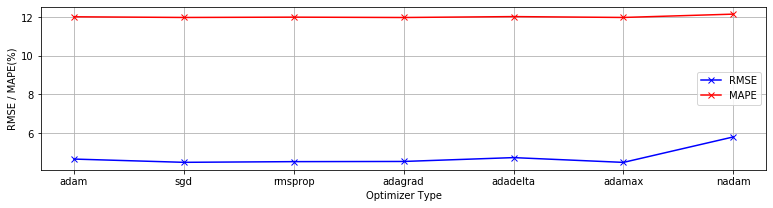

Optimal Parameter (Based on RMSE): adamax, RMSE: 4.4878889462765175


In [23]:
optimizer_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

optimizer_errors = {'Optimizer' : [], 'RMSE' : [], 'MAPE' : []}

for opt in optimizer_list:   

    #Initialize the Scaler for the Training Data
    scaler = StandardScaler()

    #Fit the Scaler into the Training Data
    train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

    #Split Training Data into Features X and Outputs Y 
    x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

    #Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
    x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), timestep, 0)
    
    # Create the LSTM network
    Model = Sequential()

    #Add an LSTM Unit with Input Size train(rows, columns)
    Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add an LSTM Unit
    Model.add(LSTM(units=neurons))
    #Add a Droupout unit
    Model.add(Dropout(dropout))
    #Add a Dense Layer
    Model.add(Dense(1))

    #Configure the Model's Learning Process
    Model.compile(loss='mean_squared_error', optimizer=opt)

    #Fit the Training Data into the Model
    Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
    Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

    #Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)  
    
    #Input the Timestep & Errors to the Dataframe
    optimizer_errors['Optimizer'].append(opt)
    optimizer_errors['RMSE'].append(RMSE)
    optimizer_errors['MAPE'].append(MAPE)
    
optimizer_errors = pd.DataFrame(optimizer_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 13, 3 
AX = optimizer_errors.plot(x='Optimizer', y='RMSE', style='bx-', grid=True)
AX = optimizer_errors.plot(x='Optimizer', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Optimizer Type")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = optimizer_errors[optimizer_errors['RMSE'] == optimizer_errors['RMSE'].min()]
optimizer = OptimalParameter['Optimizer'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Optimizer'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Final Model (including Feature Engineering)

In [24]:
#Initialize the Scaler for the Training Data
scaler = StandardScaler()

#Fit the Scaler into the Training Data
train_scaled = scaler.fit_transform(np.array(train[Columns]).reshape(-1, len(Columns)))

#Split Training Data into Features X and Outputs Y 
x_train_scaled, y_train_scaled = get_input_output(train_scaled, timestep, 0)

#Split the Testing Data into Features X and Outputs Y by solely perform scaling on Features X
x_test_scaled, y_test, mu_test_list, std_test_list = get_input_scaled_output(np.array(test[Columns]).reshape(-1, len(Columns)), timestep, 0)

# Create the LSTM network
Model = Sequential()

#Add an LSTM Unit with Input Size train(rows, columns)
Model.add(LSTM(units=neurons, return_sequences=True, input_shape=(x_train_scaled.shape[1], len(Columns))))

#Add a Droupout unit
Model.add(Dropout(dropout))

#Add an LSTM Unit
Model.add(LSTM(units=neurons))

#Add a Droupout unit
Model.add(Dropout(dropout))

#Add a Dense Layer
Model.add(Dense(1))

#Configure the Model's Learning Process
Model.compile(loss='mean_squared_error', optimizer=optimizer)

#Show a summary of the Model
Model.summary()

#Fit the Training Data into the Model
Model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_283 (LSTM)              (None, 3, 10)             720       
_________________________________________________________________
dropout_283 (Dropout)        (None, 3, 10)             0         
_________________________________________________________________
lstm_284 (LSTM)              (None, 10)                840       
_________________________________________________________________
dropout_284 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 11        
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 1s - loss: 0.9691
Epoch 2/50
 - 0s - loss: 0.8882
Epoch 3/50
 - 0s - loss: 0.8052
Epoch 4/50
 - 0s - l

In [25]:
#Using the Test Inputs, Predict Values for Output & Scale them Back to Original Values
Prediction = (Model.predict(x_test_scaled) * np.array(std_test_list).reshape(-1,1)) + np.array(mu_test_list).reshape(-1,1)

#Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'][timestep:], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'][timestep:], Prediction)

#Print the values of RMSE & MAPE
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'][timestep:], 'Actual Value': test['Predicted Adj Close'][timestep:], 'Prediction': Prediction.reshape(-1)})

Prediction['Predicted Change'] = Prediction['Actual Value'].diff(periods=1)
Prediction['Predicted Change'] = Prediction['Predicted Change'].abs()

#Display the first 5 rows of this Dataframe
Prediction.head()

RMSE: 4.522594543715649
MAPE: 12.000522793104723


,Date,Actual Value,Prediction,Predicted Change
880,2018-05-30,182.389633,183.518868,NaN
881,2018-05-31,185.678833,183.247801,3.289200
882,2018-06-01,186.196136,182.801349,0.517303
883,2018-06-02,186.713440,183.248074,0.517303
884,2018-06-03,187.230743,184.231925,0.517303


### Display Final Model Predictions vs Actual Values

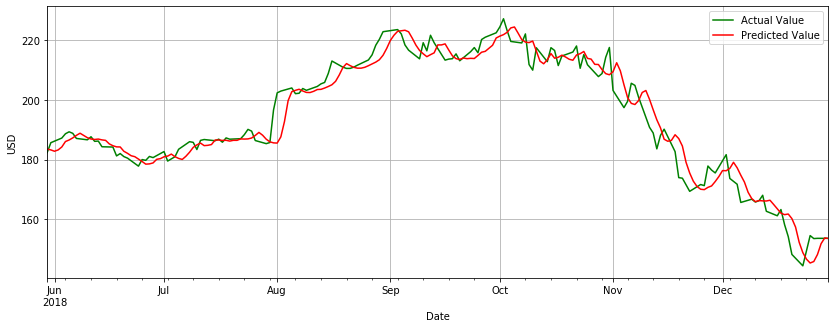

In [26]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()